<p><img alt="Colaboratory logo" height="140px" src="https://upload.wikimedia.org/wikipedia/commons/archive/f/fb/20161010213812%21Escudo-UdeA.svg" align="left" hspace="10px" vspace="0px"></p>

# **Diplomado de Análisis de datos y Machine Learning en Python**


El presente diplomado hace parte del centro de Big Data de la facultad de ciencias exactas y naturales (FCEN) de la Universidad de Antioquia.

## **Sesión 17**

## **Contenido**

- <a href="#reg"> Regularización</a><br>
- <a href="#rid"> Regresión Ridge</a><br>
- <a href="#las"> Regresión Lasso</a><br>
- <a href="#ela"> Redes elásticas</a><br>
- <a href="#gra"> Gradiente descendente</a><br>






<p><a name="reg"></a></p>

# **Regularización**

La introducción de la transformación polinomial en nuestra regresión lineal hace que el modelo sea mucho más flexible, pero también puede conducir a un sobreajuste de los datos

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
from sklearn.model_selection import train_test_split

def data(N, seed = 1):
  np.random.seed(seed)
  X = np.random.rand(N,1) ** 2
  y = 10 - 1./(X.ravel() + 0.1) + 2 * np.random.rand(N)

  return X, y

X, y = data(40)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def PolyReg(degree = 2):
  return make_pipeline(PolynomialFeatures(degree = degree),
                       LinearRegression())

In [ ]:
def PR(degree):

  model = PolyReg(degree).fit(X_train, y_train)

  print(f"train_score: {model.score(X_train, y_train)}")
  print(f"test_score: {model.score(X_test, y_test)}")

  x = np.c_[np.linspace(0,1)]
  y_pred = model.predict(x)

  plt.figure(figsize=(8,6))
  plt.scatter(X_train, y_train, label = 'Train data')
  plt.scatter(X_test, y_test, label = 'Test data')
  plt.plot(x, y_pred, 'r--', label = 'Model prediction')
  plt.legend()
  plt.ylim(0,12)
  plt.title(f'degree: {degree}')

train_score: 0.6759637756842554
test_score: 0.6573808499047218


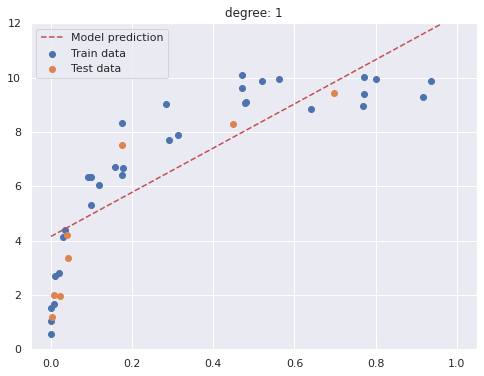

In [ ]:
PR(1)

train_score: 0.9828493483261352
test_score: -33.27778847246298


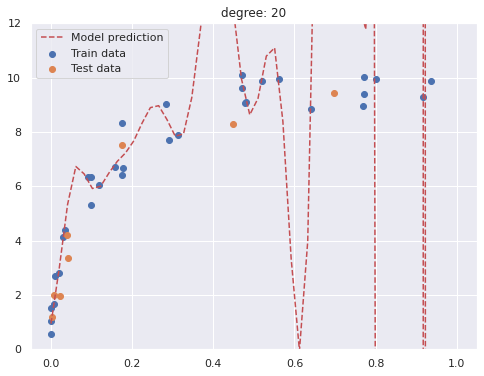

In [ ]:
PR(20)

Con los datos proyectados sobre la base de 20 dimensiones, el modelo tiene demasiada flexibilidad y llega a valores extremos entre ubicaciones donde está limitado por los datos. Podemos ver la razón de esto si graficamos los coeficientes asociados a cada potencia:


In [ ]:
model = PolyReg(20).fit(X_train, y_train)
model['linearregression'].coef_

array([ 0.00000000e+00,  2.60307626e+02, -2.13673336e+04,  1.07782271e+06,
       -2.67514938e+07,  3.67683688e+08, -2.93836669e+09,  1.23907676e+10,
       -3.50199979e+09, -2.88556868e+11,  1.91515666e+12, -6.95801462e+12,
        1.63553077e+13, -2.50911944e+13,  2.21834231e+13, -2.83088305e+12,
       -2.02080814e+13,  2.81849879e+13, -1.91098585e+13,  6.90857704e+12,
       -1.06715729e+12])

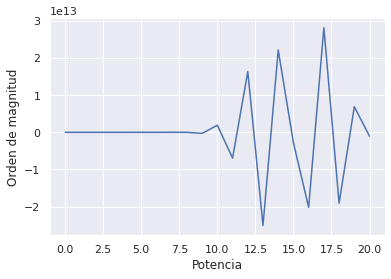

In [ ]:
plt.plot(model['linearregression'].coef_)
plt.xlabel('Potencia')
plt.ylabel('Orden de magnitud')
plt.show()


Este es un comportamiento de sobreajuste típico: los coeficientes de las potencias adyacentes varían mucho por lo que se cancelan entre sí. Sería bueno si pudiéramos limitar esos picos explícitamente en el modelo.

una buena forma de reducir el sobreajuste es restringirlo: cuantos menos grados de libertad tenga, más difícil le resultará sobreajustar los datos. Por ejemplo, una forma sencilla de regularizar un modelo polinomial es reducir el número de grados polinomiales.

Para un modelo lineal, la regularización se logra típicamente restringiendo los pesos del modelo, es decir, limitando tales picos explícitamente en el modelo penalizando los valores grandes de los parámetros del modelo. Esta penalización se conoce como regularización y se puede introducir de varias formas.







<p><a name="rid"></a></p>

# **Regresión Ridge**

La regresión Ridge también es un modelo lineal de regresión, por lo que la fórmula que usa para hacer predicciones es la misma que se usa para mínimos cuadrados ordinarios. 

Sin embargo, en esta, los coeficientes $W$ se eligen no solo para que predigan bien los datos de entrenamiento, sino también para ajustarse a una restricción adicional: **También queremos que la magnitud de los coeficientes sea lo más pequeña posible**; 

en otras palabras, todas los valores de $W$ deben ser cercanos a cero. De manera intuitiva, esto significa que cada característica debe tener el menor efecto posible en el resultado y, al mismo tiempo, predecir bien.

Esto se puede obtener penalizando la suma de los cuadrados de los coeficientes del modelo; en este caso, la penalización en el ajuste del modelo sería:

$$P = \alpha \sum_{i=1}^N w_i^2$$

Este tipo particular utilizado por la regresión Ridge se conoce como regularización L2. Tenga en cuenta que el término de sesgo $w_0$ no está regularizado. La función de costo de la regresión Ridge es entonces:

\begin{equation}
L = \frac{1}{n}\sum_{i=1}^n (\hat y_i - y_i)^2 +  \alpha  \frac{1}{2} \sum_{i=1}^m w_i^2
\end{equation}

Esto obliga al algoritmo de aprendizaje no solo a ajustar los datos, sino también a mantener los pesos del modelo lo más pequeños posible. Tenga en cuenta que el término de regularización solo debe agregarse a la función de costo durante la capacitación. Una vez que se entrena el modelo, se desea evaluar el rendimiento del modelo utilizando la métrica no regularizada.

El hiperparámetro $ \alpha $ controla cuánto deseamos regularizar el modelo. En el límite $ \alpha \rightarrow 0 $, recuperamos el resultado de la regresión lineal estándar; en el límite $ \alpha \rightarrow \infty $, todos los parámetros del modelo serán suprimidos.

Al igual que en el caso de la regresión lineal simple, existe una solución cerrada para el problema de optimización:

\begin{equation}
W = (X^TX + \alpha A)^{-1} X^T Y 
\end{equation}

donde $ A $ es la matriz de identidad $n $ × $n $, excepto con un 0 en la celda superior izquierda, correspondiente al término de sesgo.

Veamos cómo realizar la regresión Ridge con Scikit-Learn utilizando la solución cerrada:

In [ ]:
from sklearn.preprocessing import StandardScaler

def LM_scores(estimador, degree = 20):

  model = make_pipeline(PolynomialFeatures(degree), StandardScaler(),
                        estimador).fit(X_train, y_train)

  print(f"Train score: {model.score(X_train, y_train)}")
  print(f"Test score: {model.score(X_test, y_test)}")


Es importante escalar los datos antes de realizar la regresión Ridge, ya que es sensible a la escala de las características de entrada. Esto es cierto para la mayoría de los modelos regularizados.

In [ ]:
LM_scores(LinearRegression())

Train score: 0.9828443809707086
Test score: -33.65845338994819


In [ ]:
from sklearn.linear_model import Ridge

LM_scores(Ridge())

Train score: 0.8447486791850856
Test score: 0.785668334806107


La puntuación del conjunto de entrenamiento con Ridge es más baja que la de LinearRegression, mientras que la puntuación del conjunto de prueba es más alta. Esto es consistente con lo que esperabamos: Con la regresión lineal, estábamos sobreajustando nuestros datos. Ridge es un modelo más restringido, por lo que es menos probable que hagamos un sobreajuste. Un modelo menos complejo significa un peor rendimiento en el conjunto de entrenamiento, pero una mejor generalización. Como solo nos interesa el rendimiento de generalización, deberíamos elegir el modelo de Ridge sobre el modelo LinearRegression.

El aumento de $\alpha$ obliga a los coeficientes a moverse más hacia el cero, lo que disminuye el rendimiento sobre el conjunto de entrenamiento, pero podría ayudar a la generalización. 



In [ ]:
LM_scores(Ridge(alpha= 0.1))

Train score: 0.9174704092225511
Test score: 0.895600018100093


In [ ]:
LM_scores(Ridge(10))

Train score: 0.6663286798550276
Test score: 0.5244687435698415


Un $\alpha$ más alto significa un modelo más restringido, por lo que esperamos que las entradas de coef_ tengan una magnitud menor para un valor alto de $\alpha$ que para un valor bajo de $\alpha$.

In [ ]:
def LM(estimador, degree = 20):

  return make_pipeline(PolynomialFeatures(degree), 
                       StandardScaler(),
                       estimador).fit(X_train, y_train)

In [ ]:
ridge = LM(Ridge())
ridge01 = LM(Ridge(alpha=0.1))
ridge0001 = LM(Ridge(alpha=0.001))
ridge100 = LM(Ridge(alpha=100))

In [ ]:
ridge100['ridge'].coef_

array([ 0.        ,  0.43399305,  0.26534703,  0.17348434,  0.11805106,
        0.08244529,  0.05839811,  0.04142946,  0.02899904,  0.01961064,
        0.0123489 ,  0.00663105,  0.00207061, -0.00159918, -0.00456944,
       -0.0069816 , -0.00894318, -0.01053775, -0.01183133, -0.01287684,
       -0.01371709])

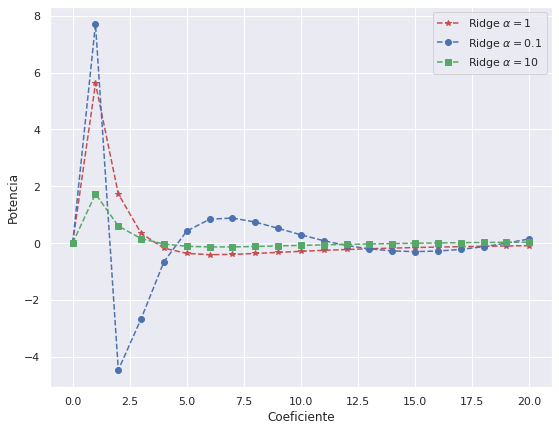

In [ ]:
plt.figure(figsize=(9,7))

plt.plot(ridge['ridge'].coef_, "r*--", label = r'Ridge $\alpha = 1$')
plt.plot(ridge01['ridge'].coef_, "bo--", label = r'Ridge $\alpha = 0.1$')
plt.plot(ridge10['ridge'].coef_, "gs--", label = r'Ridge $\alpha = 10$')
plt.xlabel('Coeficiente')
plt.ylabel('Potencia')
plt.legend();

In [ ]:
ridge['ridge'].coef_

array([ 0.        ,  4.23454587, -0.13912319, -0.8197821 , -0.75490701,
       -0.55689103, -0.36712492, -0.21568012, -0.10350583, -0.02412758,
        0.02995502,  0.06535031,  0.08733293,  0.09990762,  0.10602521,
        0.10781674,  0.10679833,  0.10403511,  0.10026623,  0.09599759,
        0.09156944])

Otra forma de entender la influencia de la regularización es fijar un valor de $\alpha$ y variar la cantidad de datos de entrenamiento:


In [ ]:
ridge

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=20, include_bias=True,
                                    interaction_only=False, order='C')),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

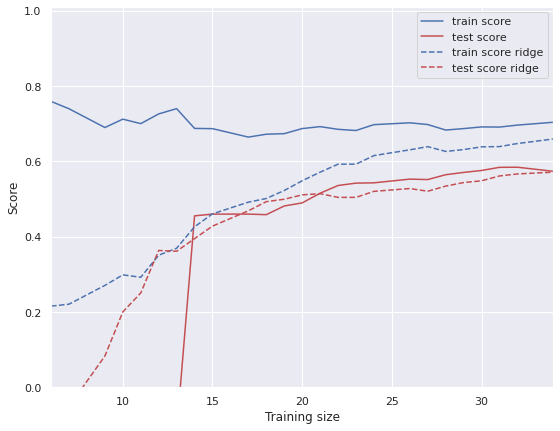

In [ ]:
from sklearn.model_selection import learning_curve


N, train_scores, test_scores = learning_curve(PolyReg(10)['linearregression'], X, y, 
                                              cv = 7, train_sizes = np.linspace(0.2, 1, 25))

N, train_scores_ridge, test_scores_ridge = learning_curve(LM(Ridge(), degree = 10)['ridge'], X, y, 
                                              cv = 7, train_sizes = np.linspace(0.2, 1, 25))
  
plt.figure(figsize=(9, 7))
plt.plot(N, np.mean(train_scores, axis= 1), 'b', label = "train score")
plt.plot(N, np.mean(test_scores, axis= 1), 'r', label = "test score")
plt.plot(N, np.mean(train_scores_ridge, axis= 1), 'b--', label = "train score ridge")
plt.plot(N, np.mean(test_scores_ridge, axis= 1), 'r--', label = "test score ridge")
plt.xlabel('Training size')
plt.ylabel('Score')
plt.xlim(N[0],N[-1])
plt.ylim(0,1.01)
plt.legend(loc = 'best');

Debido a que el modelo Ridge está regularizado, el puntaje de entrenamiento de es más bajo que el puntaje de entrenamiento para la regresión lineal. Sin embargo, el puntaje de validación para Ridge es mejor, particularmente para pequeños subconjuntos de datos. Para menos de ~ 15 puntos de datos, la regresión lineal no puede aprender nada. A medida que el modelo dispone de más y más datos, ambos modelos mejoran y, al final, la regresión lineal alcanza a la cresta. La lección aquí es que con suficientes datos de entrenamiento, la regularización se vuelve menos importante y, con suficientes datos, la regresión lineal y de Ridge tendrán el mismo rendimiento.



<p><a name="las"></a></p>

# **Regresión Lasso**

Otro tipo de regularización muy común se conoce como Lasso (Least Absolute Shrinkage and Selection Operator Regression), e implica penalizar la suma de los valores absolutos de los coeficientes de la regresión.

$$P = \alpha \sum_{i=1}^N |w_i|$$

Al igual que con la regresión ridge, el uso de lasso también restringe los coeficientes para que sean cercanos a cero, pero de una manera ligeramente diferente, llamada regularización L1. La función de costo toma la forma:

\begin{equation}
L = \frac{1}{N} \sum_{i=1}^N (\hat y_i - y_i)^2 +  \alpha \sum_{i=1}^N |w_i|
\end{equation}

La consecuencia de la regularización L1 es que cuando se usa lasso, algunos coeficientes son exactamente cero. Esto significa que el modelo ignora por completo algunas características. Esto puede verse como una forma de selección automática de las caracterpisticas. Tener algunos coeficientes exactamente cero a menudo hace que un modelo sea más fácil de interpretar y puede revelar las características más importantes de su modelo.

In [ ]:
from sklearn.linear_model import Lasso
LM_scores(Lasso(0.08))

Train score: 0.8387190966733948
Test score: 0.789527256980447


Como podemos ver, Lasso lo hace bastante mal, tanto en el entrenamiento como en el conjunto de pruebas. Esto indica que estamos subajustando los datos, ya que se usó una cantidad pequeña de características



In [ ]:
ridge = make_pipeline(PolynomialFeatures(20), Ridge()).fit(X_train, y_train)

ridge['ridge'].coef_

array([ 0.        ,  5.61614369,  1.73289116,  0.34428919, -0.17632071,
       -0.36076115, -0.40664145, -0.39566537, -0.36334697, -0.32524164,
       -0.28793417, -0.25393326, -0.22392193, -0.19780444, -0.17519063,
       -0.15561445, -0.13862681, -0.12382992, -0.11088516, -0.09950992,
       -0.08947039])

In [ ]:
lasso = LM(Lasso())

lasso['lasso'].coef_

array([ 0.        ,  1.44922987,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        ])

De manera similar a Ridge, Lasso también tiene un parámetro de regularización, alfa, que controla la fuerza con la que los coeficientes se hacen cero.

In [ ]:
lasso10 = LM(Lasso(10))
lasso01 = LM(Lasso(0.1))

In [ ]:
a = 0.4; b = 0.5

print(a, b, np.abs(a - b))
print(a ** 9, b ** 9, np.abs((a**9) - (b**9) ))

0.4 0.5 0.09999999999999998
0.0002621440000000001 0.001953125 0.0016909809999999998


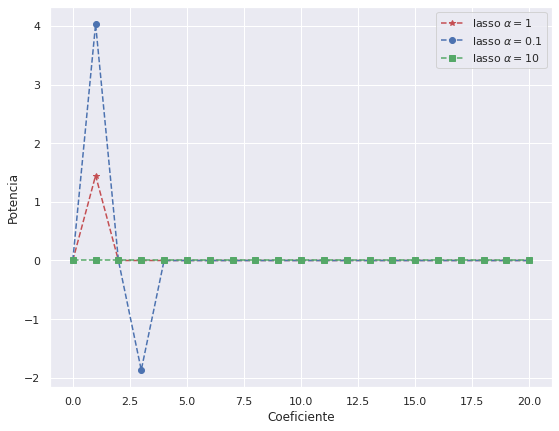

In [ ]:
plt.figure(figsize=(9,7))

plt.plot(lasso['lasso'].coef_, "r*--", label = r'lasso $\alpha = 1$')
plt.plot(lasso01['lasso'].coef_, "bo--", label = r'lasso $\alpha = 0.1$')
plt.plot(lasso10['lasso'].coef_, "gs--", label = r'lasso $\alpha = 10$')
plt.xlabel('Coeficiente')
plt.ylabel('Potencia')
plt.legend();

En la práctica, la regresión ridge suele ser la primera opción entre estos dos modelos. Sin embargo, si tiene una gran cantidad de caracteristicas y espera que solo algunas de ellas sean importantes, Lasso podría ser una mejor opción. De manera similar, si desea tener un modelo que sea fácil de interpretar, Lasso proporcionará un modelo que sea más fácil de entender, ya que seleccionará solo un subconjunto de las características de entrada.


<p><a name="ela"></a></p>

# **Redes Elásticas**

scikit-learn también proporciona la clase `ElasticNet`, que combina las penalizaciones de Lasso y Ridge. El término de regularización es una combinación simple de los términos de regularización de Ridge y Lasso, y podemos controlar la proporción de mezcla $r$

$$L =\frac{1}{N} \sum (y_i- \hat y_i)^2+\alpha r \sum_{i=1}^N |w_i| + \frac{\alpha(1-r)}{2}\sum_{i=1}^N w_i^2 $$

In [ ]:
from sklearn.linear_model import ElasticNet
LM_scores(ElasticNet(alpha= 0.1, l1_ratio=0.4))

Train score: 0.787065983800657
Test score: 0.7090556645077674


In [ ]:
plt.figure(figsize=(9,7))

plt.plot(lasso['lasso'].coef_, "r*--", label = r'lasso $\alpha = 1$')
plt.plot(lasso01['lasso'].coef_, "bo--", label = r'lasso $\alpha = 0.1$')
plt.plot(lasso10['lasso'].coef_, "gs--", label = r'lasso $\alpha = 10$')
plt.xlabel('Coeficiente')
plt.ylabel('Potencia')
plt.legend();

Entonces, ¿cuándo debe usar Regresión lineal, Ridge, Lasso o Elastic Net? Casi siempre es preferible tener al menos un poco de regularización, por lo que generalmente debe evitar la Regresión lineal simple. Ridge es un buen valor predeterminado, pero si sospecha que solo algunas características son realmente útiles, debería preferir Lasso o Elastic Net, ya que tienden a
para reducir el peso de las características inútiles a cero, como hemos discutido. En general, se prefiere Elastic Net a Lasso, ya que Lasso puede comportarse de forma errática cuando el número de funciones es mayor que el número de instancias de entrenamiento o cuando varias funciones están fuertemente correlacionadas.

<p><a name="gra"></a></p>

# **Gradiente descendente (GD)**





Hasta el momento hemos realizado el siguiente proceso

$$\hat{y}(X) = W^T X \; \rightarrow \; L \; \rightarrow \; W = (X^TX)^{-1} X^T y$$

La complejidad computacional asociada con la inversión de la matrix $X^TX$, que es una matriz de $m \times m$, es alrededor de 



$$O(m^{3})$$  

donde $m$ es el número de características en el conjunto de datos.

Existen formas diferentes de entrenar un modelo de regresión lineal, más adecuado para casos en los que hay una gran cantidad de características o demasiadas instancias de entrenamiento para que quepan en la memoria. Un algoritmo con estas características es el del gradiente descendente.

La idea general del algoritmo de gradiente descendente es ajustar los parámetros  $w_i$  de forma iterativa para minimizar la función de costo. Básicamente, este algoritmo mide el gradiente local de la función de costo con respecto a los parámetros  $w_i$ , y va en la dirección del gradiente descendente. Una vez que el gradiente es cero se ha alcanzado un mínimo.

**Batch GD**

Concretamente, comienza rellenando $W$ con valores aleatorios, y luego lo mejora gradualmente, dando un pequeño paso a la vez, cada paso intentando disminuir la función de costo hasta que el algoritmo converja al mínimo.

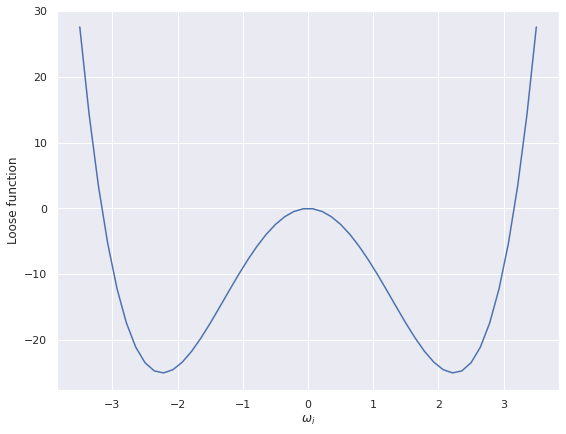

In [ ]:
x = np.linspace(-3.5, 3.5)
y = x ** 4 - 10 *x **2 
plt.figure(figsize=(9,7))
plt.plot(x, y)
plt.ylabel('Loose function')
plt.xlabel(r'$\omega_i$');

Un parámetro importante es el tamaño de los pasos, determinado por el hiperparámetro $\eta$, conocido como *tasa de aprendizaje*. Si este es muy pequeño, el algoritmo tomará mucho tiempo en converger al mínimo o si es muy grande podríamos incluso alejarnos del mínimo. Este valor puede ser constante o variar paso a paso. 

Además, debemos definir cuándo terminar el algoritmo. Esto se puede hacer mediante el hiperparámetro $e$, correspondiente a la *tolerancia*.

Cada paso en el algoritmo está dado por:

\begin{equation}
W^{next} = W - \eta \nabla_{w} L 
\end{equation}

donde 

$$\nabla_{w} L  = \frac{2}{n} X^T\cdot (X \cdot W - y)$$

No todas las funciones de costo se ven como "bowls" normales. Puede haber agujeros, crestas, mesetas y todo tipo de terrenos irregulares, lo que dificulta la convergencia al mínim


**GD Estocástico**

El principal problema con el *Batch GD* es el hecho de que utiliza todo el conjunto de entrenamiento para calcular los gradientes en cada paso, lo que lo hace muy lento cuando el conjunto de entrenamiento es muy grande.

En el extremo opuesto, el *GD Estocástico* solo elige una instancia aleatoria en el conjunto de entrenamiento en cada paso y calcula los gradientes basándose solo en esa única instancia. Obviamente, esto hace que el algoritmo sea mucho más rápido, ya que tiene muy pocos datos para manipular en cada iteración. También permite entrenar en grandes conjuntos de entrenamiento, ya que solo una instancia debe estar en memoria en cada iteración.

Por usar una única instancia en cada iteración, este algoritmo es menos estable que el *Batch GD*, lo que podría por ejemplo permitir salir de mínimos globles que no corresponden con el mínimo real.


In [ ]:
from sklearn.linear_model import SGDRegressor
SGDRegressor?

In [ ]:
model_GD = SGDRegressor(learning_rate='constant', max_iter=3000).fit(X_train, y_train)

In [ ]:
model_GD.score(X_test, y_test)

0.6176369446135122